In [1]:
import pandas as pd

from IPython.display import HTML

from rdkit import Chem
from rdkit.Chem import PandasTools, Descriptors, rdmolops
from rdkit.Chem.MolStandardize.rdMolStandardize import StandardizeSmiles

In [2]:
# Defining a function to print all structures in mol correctly
def show_df(df):
    return HTML(df.to_html(notebook=True))

# Read CSV

In [3]:
approved_drugs = pd.read_csv("../data/manual_curated_datasets/concatenated_dataset.csv")
approved_drugs.head(5)

,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,mw
0,ACETOHYDROXAMIC ACID,CC(=O)NO,CHEMBL734,1983,Small molecule,Enzyme Inhibitor (urease),0,False,0,True,0,True,False,False,75.0320284
1,HYDROXYUREA,NC(=O)NO,CHEMBL467,1967,Small molecule,Antineoplastic,0,False,0,True,0,True,False,False,76.027277368
2,CYSTEAMINE,NCCS,CHEMBL602,1994,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,0,True,False,True,77.029920224
3,DIMETHYL SULFOXIDE,C[S+](C)[O-],CHEMBL504,1978,Small molecule,Anti-Inflammatory (topical),0,False,0,True,0,False,True,False,78.013935812
4,FOMEPIZOLE,Cc1cn[nH]c1,CHEMBL1308,1997,Small molecule,Antidote (alcohol dehydrogenase inhibitor),0,False,0,True,0,False,True,False,82.053098192


# REMOVE UNWANTED MOLECULES

some molecules that were removed from the manually curated fragments dataset, are still present in the main dataset. We are going to remove them here

In [4]:
# list of pref_names to be removed
remove_structures = [
"AMMONIUM LACTATE",
"SEVELAMER",
"MESNA",
"ALUMINUM ACETATE",
"AMIFAMPRIDINE PHOSPHATE",
"LITHIUM CITRATE",
"SEVELAMER CARBONATE",
"CYSTEAMINE BITARTRATE",
"PINACIDIL",
"LITHIUM CITRATE",
"SULFADIAZINE, SILVER",
"METHYLENE BLUE",
"ACRISORCIN",
"DIMENHYDRINATE",
"BUTORPHANOL TARTRATE",
"OMEGA-3-CARBOXYLIC ACIDS",
"CEFIDEROCOL SULFATE TOSYLATE",
"GENTAMICIN SULFATE"
]

In [5]:
approved_drugs[approved_drugs["pref_name"].isin(remove_structures)]

,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,mw
39,MESNA,O=S(=O)(O)CCS,CHEMBL1098319,1988,Small molecule,Detoxifying Agent,0,False,0,True,0,True,True,False,141.975836052
324,PINACIDIL,CC(N/C(=N\C#N)Nc1ccncc1)C(C)(C)C,CHEMBL1159,1989,Small molecule,Antihypertensive,0,False,0,True,0,True,False,False,245.164045608
530,METHYLENE BLUE,CN(C)c1ccc2nc3ccc(=[N+](C)C)cc-3sc2c1,CHEMBL191083,2016,Small molecule,Antidote (to cyanide poisoning); Antimethemogl...,0,False,0,True,0,False,True,False,284.12159499609


In [6]:
approved_drugs = approved_drugs.drop([39, 324, 530])

In [7]:
approved_drugs.shape

(2821, 15)

# KEEP RIGHT FRAGMENTS

This concatenated dataset contains the three datasets joined in the formed jupyter notebook:

- Main Dataset
- Curated fragments Dataset
- Curated SMILES and Years Dataset

In the curated fragments dataset, we removed some molecules that are irrelevant for the research in question. We also selected a few molecules that are smaller than their fragments, so we will keep the smallest fragment for them. 

On the mains dataset, several molecules still contain their fragments. We will remove the fragments for all these molecules, keeping the largest fragment (the drug).

In [8]:
# Creating MOL column
PandasTools.AddMoleculeColumnToFrame(approved_drugs, smilesCol="SMILES")

RDKit WARNING: [15:52:46] WARNING: not removing hydrogen atom without neighbors
[15:52:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:52:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:52:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:52:46] WARNING: not removing hydrogen atom without neighbors
[15:52:46] WARNING: not removing hydrogen atom without neighbors
[15:52:46] WARNING: not removing hydrogen atom without neighbors
[15:52:46] WARNING: not removing hydrogen atom without neighbors
[15:52:46] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [15:52:46] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [15:52:46] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:52:46] Explicit valence for atom # 0 N, 4, is greater than permitted


In [9]:
# Two molecules contain Pt, and can't be turned into mol correctly, we will remove them

approved_drugs = approved_drugs[~approved_drugs["ROMol"].isnull()].reset_index(drop=True)
approved_drugs.shape

(2819, 16)

In [10]:
# These are the drugs (pref_name) that are smaller than their fragments. 
# The special function keep_smallest_fragment, will be applied for them.

keep_smallest = [
    "METHENAMINE HIPPURATE",
    "DEXTROAMPHETAMINE SACCHARATE",
    "IMIPRAMINE PAMOATE",
    "HYDROXYZINE PAMOATE",
    "OLANZAPINE PAMOATE",
    "PIPERAZINE CITRATE",
]

In [11]:
# Keep fragments functions

def keep_largest_fragment(mol):
    '''
    This function reads a mol object and returns the largest fragment, as mol
    '''
    frags = rdmolops.GetMolFrags(mol, asMols=True)
    largest_mol = max(frags, key=lambda x: x.GetNumAtoms())
    return largest_mol

def keep_smallest_fragment(mol):
    '''
    This function reads a mol object and returns the smallest fragment, as mol
    '''
    frags = rdmolops.GetMolFrags(mol, asMols=True)
    smallest_mol = min(frags, key=lambda x: x.GetNumAtoms())
    return smallest_mol

def keep_correct_fragment(row):
    '''
    This function recieves a DataFrame row, analyzes if it need the keep_largest_fragment or keep_smallest_fragment
    function applied to it, and returns the correct fragment, as SMILES
    '''
    if row["pref_name"] in keep_smallest:
        frag = keep_smallest_fragment(row["ROMol"])
    else:
        frag = keep_largest_fragment(row["ROMol"])
    return Chem.MolToSmiles(frag)
    

In [12]:
approved_drugs["correct_fragment"] = approved_drugs.apply(keep_correct_fragment, axis=1)

(2819, 17)


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,mw,ROMol,correct_fragment
0,ACETOHYDROXAMIC ACID,CC(=O)NO,CHEMBL734,1983,Small molecule,Enzyme Inhibitor (urease),0,False,0,True,0,True,False,False,75.0320284,,CC(=O)NO
1,HYDROXYUREA,NC(=O)NO,CHEMBL467,1967,Small molecule,Antineoplastic,0,False,0,True,0,True,False,False,76.027277368,,NC(=O)NO
2,CYSTEAMINE,NCCS,CHEMBL602,1994,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,0,True,False,True,77.029920224,,NCCS
3,DIMETHYL SULFOXIDE,C[S+](C)[O-],CHEMBL504,1978,Small molecule,Anti-Inflammatory (topical),0,False,0,True,0,False,True,False,78.013935812,,C[S+](C)[O-]
4,FOMEPIZOLE,Cc1cn[nH]c1,CHEMBL1308,1997,Small molecule,Antidote (alcohol dehydrogenase inhibitor),0,False,0,True,0,False,True,False,82.053098192,,Cc1cn[nH]c1

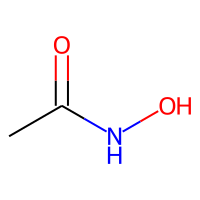
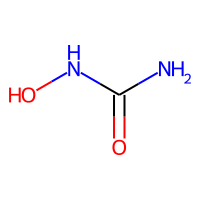
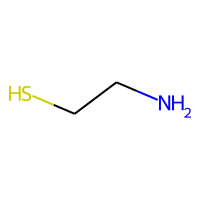
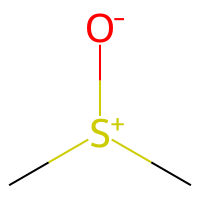
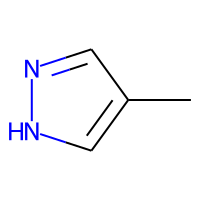

In [13]:
print(approved_drugs.shape)
show_df(approved_drugs.head())

,pref_name,ROMol,correct_fragment
2068,METHENAMINE HIPPURATE,,C1N2CN3CN1CN(C2)C3
2077,DEXTROAMPHETAMINE SACCHARATE,,C[C@H](N)Cc1ccccc1
2273,PIPERAZINE CITRATE,,C1CNCCN1
2283,PIPERAZINE CITRATE,,O
2308,OLANZAPINE PAMOATE,,O
2322,HYDROXYZINE PAMOATE,,OCCOCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1
2352,IMIPRAMINE PAMOATE,,CN(C)CCCN1c2ccccc2CCc2ccccc21

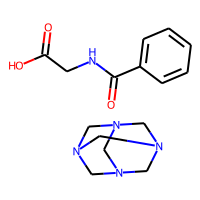
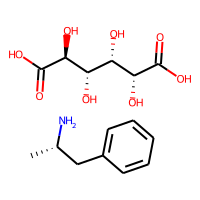
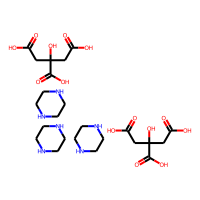
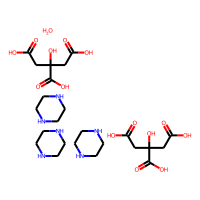
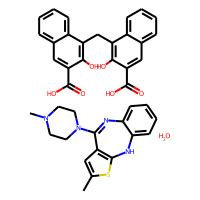
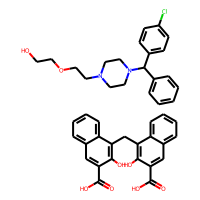
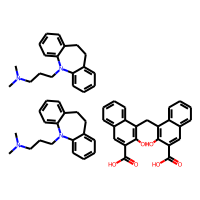

In [14]:
# checking manually if the smallest fragmente molecules are correct

show_df(approved_drugs[approved_drugs["pref_name"].isin(keep_smallest)][["pref_name", "ROMol", "correct_fragment"]])

We can see that most molecules chose the correct SMILES. However, the followinf ones showed problems:

- PIPERAZINE CITRATE
- OLANZAPINE PAMOATE

As PIPERAZINE CITRATE showed up twice, and the correct fragment was selected in the first one, we can just drop the molecules with the index that had problems.

For OLANZAPINE PAMOATE, we have manually selected the correct fragmente, which is Cc1cc2c(s1)Nc1ccccc1N=C2N1CCN(C)CC1.

In [15]:
# dropping the wrong PIPERAZINE CITRATE (index 2283)

approved_drugs = approved_drugs.drop(2283)

In [16]:
# manually correcting OLANZAPINE PAMOATE

approved_drugs.loc[2308, "correct_fragment"] = "Cc1cc2c(s1)Nc1ccccc1N=C2N1CCN(C)CC1"
approved_drugs.loc[2308, "correct_fragment"]

'Cc1cc2c(s1)Nc1ccccc1N=C2N1CCN(C)CC1'

In [17]:
approved_drugs = approved_drugs.reset_index(drop=True)

# Neutralizing and Standardizing molecules

We need to neutralize the molecules before looking for duplicates.

We also need to standardizer the SMILES, to be sure same molecules have the same SMILES string (we do this by transforming the SMILES into mol, then into SMILES again).

In [18]:
def neutralize_standardize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return Chem.MolToSmiles(mol)

In [19]:
# calculate ROMol from the correct smiles
approved_drugs = approved_drugs.drop("ROMol", axis=1)
PandasTools.AddMoleculeColumnToFrame(approved_drugs, smilesCol="correct_fragment")

In [20]:
approved_drugs["correct_fragment"] = approved_drugs["ROMol"].apply(neutralize_standardize_atoms)

,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,mw,correct_fragment,ROMol
0,ACETOHYDROXAMIC ACID,CC(=O)NO,CHEMBL734,1983,Small molecule,Enzyme Inhibitor (urease),0,False,0,True,0,True,False,False,75.0320284,CC(=O)NO,
1,HYDROXYUREA,NC(=O)NO,CHEMBL467,1967,Small molecule,Antineoplastic,0,False,0,True,0,True,False,False,76.027277368,NC(=O)NO,
2,CYSTEAMINE,NCCS,CHEMBL602,1994,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,0,True,False,True,77.029920224,NCCS,
3,DIMETHYL SULFOXIDE,C[S+](C)[O-],CHEMBL504,1978,Small molecule,Anti-Inflammatory (topical),0,False,0,True,0,False,True,False,78.013935812,C[S+](C)[O-],
4,FOMEPIZOLE,Cc1cn[nH]c1,CHEMBL1308,1997,Small molecule,Antidote (alcohol dehydrogenase inhibitor),0,False,0,True,0,False,True,False,82.053098192,Cc1cn[nH]c1,

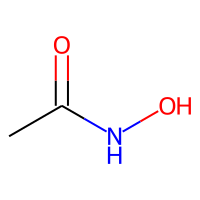
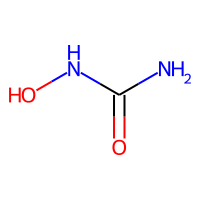
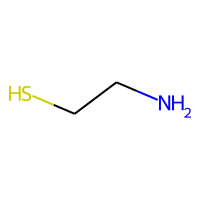
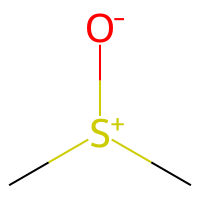
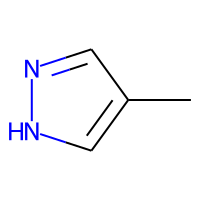

In [21]:
approved_drugs.shape
show_df(approved_drugs.head())

# Checking for Repeated Molecules

The original dataset has repeated molecules. It also had molecules in salt form and neutral form. We performed nautralization in the molecules, therefore, these molecules are now the same. We need to remove all of these repeated molecules, but withou losing information about their parameters.

### Analyzing number of unique molecules in the dataset  

In [22]:
whole_dataset_size = len(approved_drugs)
number_unique_molecules = len(approved_drugs["correct_fragment"].unique())

print(f"Whole dataset: {whole_dataset_size}\n\
Unique molecules: {number_unique_molecules}\n\
      ")


Whole dataset: 2818
Unique molecules: 1908
      


### Separating Datasets with only unique molecules, and only repeated ones

In [23]:
# separating dataset with only repeated molecules
recurents = approved_drugs[approved_drugs["correct_fragment"].duplicated(keep=False)]
recurents.shape

(1731, 17)

In [24]:
# separating dataset with only unique molecules
approved_drugs = approved_drugs[~approved_drugs["correct_fragment"].duplicated(keep=False)]
approved_drugs.shape

(1087, 17)

In [25]:
print(
    f"""
    Number of molecules in the dataset with only unique molecules: {len(approved_drugs)}
                                                                        +
    Number of unique molecules in the dataset with only repeated :  {len(recurents["correct_fragment"].unique())}
                                                                  -------
    Number of molecules in the finished dataset (unique molecules): {len(approved_drugs) + len(recurents["correct_fragment"].unique())}
    """
)


    Number of molecules in the dataset with only unique molecules: 1087
                                                                        +
    Number of unique molecules in the dataset with only repeated :  821
                                                                  -------
    Number of molecules in the finished dataset (unique molecules): 1908
    


### Selecting parameters for repeated molecules

Repeated molecules occupy different rows in the original dataset. That happens because different forms can be approved over the years, with differente approval years, form of admnistrations, and other parameters. Here, we will join repeated molecules into one row, mixing their parameters in the following way:

- pref_name -> Smallest Name (no salt)
- smiles -> Any Entry
- molecule_chembl_id -> Any Entry
- first_approval  -> Oldest Year
- molecule_type -> Any Entry
- indication_class -> Biggest Description
- polymer_flag -> Any Entry
- withdrawn_flag -> Any True (only false if all are false)
- inorganic_flag -> Any Entry
- therapeutic_flag -> Any Entry
- natural product -> Any True (only false if all are false)
- oral -> Any True (only false if all are false)
- parenteral -> Any True (only false if all are false)
- topical -> Any True (only false if all are false)
- mw -> Any Entry
- correct_fragment -> Any Entry
- ROMol -> Any Entry

In [26]:
recurents = recurents.reset_index(drop=True)

We need to adjust the fir approval data type. Currently, it is an object, containing both int and str. We need all of them to be int. However, as some of them are the string "Not Found", we will change these to 9999. Our goal with the first approval is to find the oldest year, therefore, this won't affect our algorithm.

In [27]:
recurents.query("first_approval == 'not found'").shape

(120, 17)

In [28]:
recurents.loc[recurents.first_approval == 'not found', "first_approval"] = 9999
recurents.query("first_approval == 9999").shape

(120, 17)

In [29]:
# fixing the data type in the dataset
recurents["first_approval"] = pd.to_numeric(recurents["first_approval"])

types = {
    "pref_name": "str",
    "molecule_chembl_id": "str",
    "first_approval": "int32",
    "molecule_type": "category",
    "indication_class": "str",
}

recurents = recurents.astype(types)

recurents.dtypes

pref_name               object
SMILES                  object
molecule_chembl_id      object
first_approval           int32
molecule_type         category
indication_class        object
polymer_flag             int64
withdrawn_flag            bool
inorganic_flag           int64
therapeutic_flag          bool
natural_product          int64
oral                      bool
parenteral                bool
topical                   bool
mw                      object
correct_fragment        object
ROMol                   object
dtype: object

Now, we will create the funcions to look for all the repeated molecules, and choose the relevant parameters for each one. It is interesting to note that, as SMILES, some special characters might appear, such as \n. To deal with this, we must use the smiles as raw string, by the use of `r` in the search function. 

In [30]:
def get_recurent_by_smiles(index):
    """
    This functions recieves a row, and looks for all rows in the recurents dataset that has the same SMILES in the correct_fragment
    It returns the df with repeated molecules, and a list with their indexes
    """

    repeats = recurents.query(f"correct_fragment == r'{recurents.loc[index, 'correct_fragment']}'")
    return repeats, repeats.index.to_list()

def any_true(column):
    if sum(column) == 0:
        return False
    else:
        return True


def choose_right_parameters(repeats):
    """
    This funcion chooses the right parameters to be added to the non-repeated dataset.It returns them as a list
    """

    # pref_name --> smallest name (no salt)

    names_len = repeats["pref_name"].str.len()
    smallest_name = repeats[names_len == names_len.min()].sample()
    pref_name = smallest_name["pref_name"].values[0]

    # SMILES --> anyone
    smiles = smallest_name["SMILES"].values[0]

    # molecule_chembl_id --> same one as the name
    molecule_chembl_id = smallest_name["molecule_chembl_id"].values[0]

    # first approval --> smallest year
    first_approval = repeats["first_approval"].min()

    # molecule_type --> all the same
    molecule_type = smallest_name["molecule_type"].values[0]

    # indication_class --> biggest string
    biggest_name = repeats[names_len == names_len.max()].sample()
    indication_class = biggest_name["pref_name"].values[0]

    # polymer_flag --> all the same
    polymer_flag = smallest_name["polymer_flag"].values[0]

    # withdrawn_flag --> or gate
    withdrawn_flag = any_true(repeats["withdrawn_flag"])

    # inorganic_flag --> all the same
    inorganic_flag = smallest_name["inorganic_flag"].values[0]

    # therapeutic_flag --> all the same
    therapeutic_flag = smallest_name["therapeutic_flag"].values[0]

    # natural_product --> or gate
    natural_product = any_true(repeats["natural_product"])

    # oral --> or gate
    oral = any_true(repeats["oral"])

    # parenteral --> or gate
    parenteral = any_true(repeats["parenteral"])

    # topical --> or gate
    topical = any_true(repeats["topical"])

    # mw --> all the same
    mw = smallest_name["mw"].values[0]

    # correct_fragment --> all the same
    correct_fragment = smallest_name["correct_fragment"].values[0]

    # ROMol --> all the same
    ROMol = smallest_name["ROMol"].values[0] 

    return [
        pref_name, smiles, molecule_chembl_id, first_approval,
        molecule_type, indication_class, polymer_flag, withdrawn_flag,
        inorganic_flag, therapeutic_flag, natural_product, oral,
        parenteral, topical, mw, correct_fragment, ROMol
    ]

In [31]:
already_seen = []
repeated_cleaned = {}

for index in range(len(recurents)):
    # continue if we have already checked that molecule
    if index in already_seen:
        continue
    
    else:
        repeated_df, repeated_indexes = get_recurent_by_smiles(index)

        repeated_cleaned[index] = choose_right_parameters(repeated_df)

        # add indexes to already_seen
        already_seen.extend(repeated_indexes)

In [32]:
# just to be sure, we can check if the number of molecules in the repested_cleaned is the same
# as the number of unique molecules in the recurents dataset

print(f"{len(repeated_cleaned)} == {len(recurents['correct_fragment'].unique())}")

821 == 821


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,mw,correct_fragment,ROMol
0,CYSTEAMINE,NCCS,CHEMBL602,1994,Small molecule,CYSTEAMINE HYDROCHLORIDE,0,False,0,True,False,True,False,True,77.029920224,NCCS,
1,OXYBATE,O=C(O)CCCO,CHEMBL1342,2002,Small molecule,SODIUM OXYBATE,0,False,0,True,False,True,False,False,104.047344116,O=C(O)CCCO,
2,BETAZOLE,NCCc1cc[nH]n1,CHEMBL1201323,1982,Small molecule,BETAZOLE HYDROCHLORIDE,0,False,0,True,False,False,True,False,111.079647288,NCCc1cc[nH]n1,
3,HISTAMINE,NCCc1c[nH]cn1,CHEMBL90,1939,Small molecule,HISTAMINE DIHYDROCHLORIDE,0,False,0,True,False,False,True,False,111.079647288,NCCc1c[nH]cn1,
5,BETAINE,C[N+](C)(C)CC(=O)O,CHEMBL95889,1996,Small molecule,BETAINE HYDROCHLORIDE,0,False,0,True,False,True,False,False,118.08625504409,C[N+](C)(C)CC(=O)O,

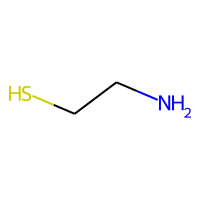
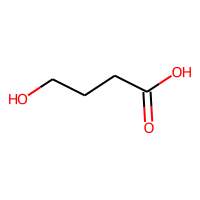
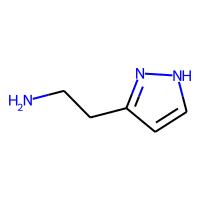
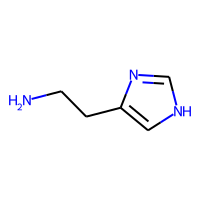
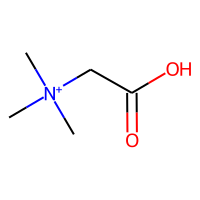

In [33]:
repeated_cleaned_df = pd.DataFrame.from_dict(repeated_cleaned, orient="index", columns=recurents.columns)
show_df(repeated_cleaned_df.head())

In [34]:
approved_drugs = pd.concat([approved_drugs, repeated_cleaned_df]).reset_index(drop=True)

(1908, 17)


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,mw,correct_fragment,ROMol
0,ACETOHYDROXAMIC ACID,CC(=O)NO,CHEMBL734,1983,Small molecule,Enzyme Inhibitor (urease),0,False,0,True,0,True,False,False,75.0320284,CC(=O)NO,
1,HYDROXYUREA,NC(=O)NO,CHEMBL467,1967,Small molecule,Antineoplastic,0,False,0,True,0,True,False,False,76.027277368,NC(=O)NO,
2,DIMETHYL SULFOXIDE,C[S+](C)[O-],CHEMBL504,1978,Small molecule,Anti-Inflammatory (topical),0,False,0,True,0,False,True,False,78.013935812,C[S+](C)[O-],
3,FOMEPIZOLE,Cc1cn[nH]c1,CHEMBL1308,1997,Small molecule,Antidote (alcohol dehydrogenase inhibitor),0,False,0,True,0,False,True,False,82.053098192,Cc1cn[nH]c1,
4,LACTIC ACID,CC(O)C(=O)O,CHEMBL1200559,2006,Small molecule,NaN,0,False,0,True,0,False,True,False,90.031694052,CC(O)C(=O)O,

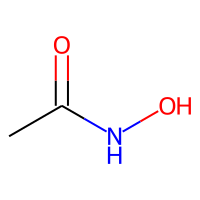
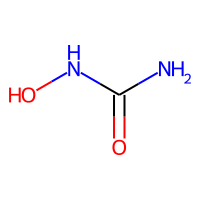
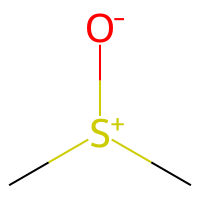
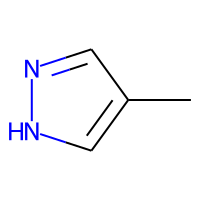
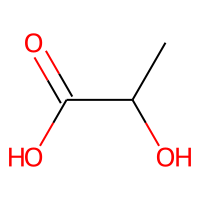

In [35]:
approved_drugs = approved_drugs.reset_index(drop=True)

print(approved_drugs.shape)
show_df(approved_drugs.head())

In [36]:
len(approved_drugs.query("first_approval == 9999"))

50

We can see that, in the new dataset, only 50 molecules have the first_approval as 9999 (Not Found). Before looking for all the repeated molecules, it was at 120 molecules. In this search, 70 molecules has their approval year found, already present in the dataset!

### ORDER BY MW

I will drop the MW collumn, and reclaculate it, because we standardized the SMILES. It shouldn't matter, but better safe than sorry.

In [37]:
# removing MW collumn
approved_drugs = approved_drugs.drop(["mw", "ROMol"], axis=1)

In [38]:
# recalculating MW
PandasTools.AddMoleculeColumnToFrame(approved_drugs, smilesCol="correct_fragment")

In [39]:
# Searching for molecules that can't be transformed to mol by rdkit
approved_drugs[approved_drugs["ROMol"].isnull()]

,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,correct_fragment,ROMol


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,correct_fragment,ROMol,mw
0,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N,CHEMBL1200728,1939,Small molecule,NaN,0,False,0,True,0,True,False,False,N=C(N)N,,59.048347
1,ACETOHYDROXAMIC ACID,CC(=O)NO,CHEMBL734,1983,Small molecule,Enzyme Inhibitor (urease),0,False,0,True,0,True,False,False,CC(=O)NO,,75.032028
2,HYDROXYUREA,NC(=O)NO,CHEMBL467,1967,Small molecule,Antineoplastic,0,False,0,True,0,True,False,False,NC(=O)NO,,76.027277
3,CYSTEAMINE,NCCS,CHEMBL602,1994,Small molecule,CYSTEAMINE HYDROCHLORIDE,0,False,0,True,False,True,False,True,NCCS,,77.029920
4,DIMETHYL SULFOXIDE,C[S+](C)[O-],CHEMBL504,1978,Small molecule,Anti-Inflammatory (topical),0,False,0,True,0,False,True,False,C[S+](C)[O-],,78.013936

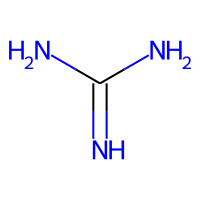
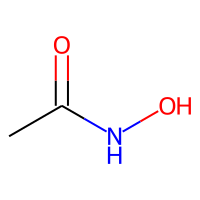
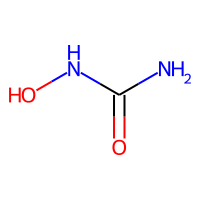
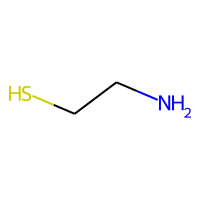
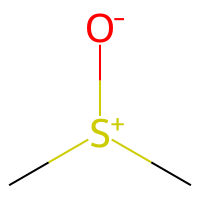

In [40]:
# calculating and ordering by MW
approved_drugs['mw'] = approved_drugs['ROMol'].apply(Descriptors.ExactMolWt)

approved_drugs = approved_drugs.sort_values(by="mw", ascending=True)

approved_drugs = approved_drugs.reset_index(drop=True)

show_df(approved_drugs.head())

# Organizing columns

In [41]:
relevant_columns = [
    "pref_name", 
    "molecule_chembl_id",
    "correct_fragment",
    "first_approval",
    "indication_class",
    "molecule_type",
    "therapeutic_flag",
    "polymer_flag",
    "inorganic_flag",
    "natural_product",
    "oral",
    "parenteral",
    "topical"
]

In [42]:
approved_drugs = approved_drugs[relevant_columns]
approved_drugs.head()

,pref_name,molecule_chembl_id,correct_fragment,first_approval,indication_class,molecule_type,therapeutic_flag,polymer_flag,inorganic_flag,natural_product,oral,parenteral,topical
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,True,0,0,0,True,False,False
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,True,0,0,0,True,False,False
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,True,0,0,0,True,False,False
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,True,0,0,False,True,False,True
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,True,0,0,0,False,True,False


In [43]:
# renaming columns

new_names = {
    "pref_name": "name", 
    "molecule_chembl_id": "chembl_id",
    "correct_fragment": "clean_smiles",
    "first_approval": "first_approval_year",
    "indication_class": "indication_class",
    "molecule_type": "molecule_type",
    "natural_product": "natural_product_flag",
}

approved_drugs = approved_drugs.rename(columns=new_names)

approved_drugs.head(3)

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,oral,parenteral,topical
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,True,0,0,0,True,False,False
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,True,0,0,0,True,False,False
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,True,0,0,0,True,False,False


In [44]:
# correcting varibles types
approved_drugs.dtypes

name                    object
chembl_id               object
clean_smiles            object
first_approval_year     object
indication_class        object
molecule_type           object
therapeutic_flag          bool
polymer_flag             int64
inorganic_flag           int64
natural_product_flag    object
oral                      bool
parenteral                bool
topical                   bool
dtype: object

In [45]:
boolean_columns = [
    "therapeutic_flag",          
    "polymer_flag",        
    "inorganic_flag",           
    "natural_product_flag",    
    "oral",                      
    "parenteral",                
    "topical",                   
]

approved_drugs[boolean_columns] = approved_drugs[boolean_columns].astype(bool)

approved_drugs.dtypes

name                    object
chembl_id               object
clean_smiles            object
first_approval_year     object
indication_class        object
molecule_type           object
therapeutic_flag          bool
polymer_flag              bool
inorganic_flag            bool
natural_product_flag      bool
oral                      bool
parenteral                bool
topical                   bool
dtype: object

In [46]:
print(approved_drugs.shape)
approved_drugs.head()

(1908, 13)


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,oral,parenteral,topical
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,True,False,False,False,True,False,False
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,True,False,False,False,True,False,False
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,True,False,False,False,True,False,False
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,True,False,False,False,True,False,True
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,True,False,False,False,False,True,False


In [47]:
# saving dataset

approved_drugs.to_csv("../data/pre_cleaned_datasets/pre_cleaned_unique.csv", index=False)